In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import rasterio
import tqdm
import pandas as pd
import rasterio
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [2]:
path_data = "/home/gt/DATA/geolifeclef-2025"
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata = train_metadata.dropna(subset="speciesId").reset_index(drop=True)
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)
train_label_dict = train_metadata.groupby('surveyId')['speciesId'].apply(list).to_dict()
train_metadata = train_metadata.drop_duplicates(subset="surveyId").reset_index(drop=True).drop('speciesId', axis=1)
train_metadata['areaInM2'].fillna((train_metadata['areaInM2'].mean()), inplace=True)
train_metadata["conFra"] = train_metadata["country"] == "France"
train_metadata["conDen"] = train_metadata["country"] == "Denmark"
train_metadata["conNet"] = train_metadata["country"] == "Netherlands"
train_metadata["conIta"] = train_metadata["country"] == "Italy"
train_metadata["conOther"] = ~train_metadata["country"].isin(["France","Denmark","Netherlands","Italy"])
train_elevation = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "Elevation", "GLC25-PA-train-elevation.csv"))
train_elevation['Elevation'].fillna((train_elevation['Elevation'].mean()), inplace=True)
train_soil = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "SoilGrids", "GLC25-PA-train-soilgrids.csv"))
meta_columns = ["areaInM2", "Elevation", "conFra", "conDen", "conNet", "conIta", "conOther"]

In [300]:
path_data = "/home/gt/DATA/geolifeclef-2025"
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)
train_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874,212
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476,212
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157,212
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784,212
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530,212
...,...,...,...,...,...,...,...,...,...
1483632,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,53,3919655
1483633,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,5071,3919655
1483634,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,1889,3919655
1483635,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,10600,3919655


In [270]:
display((train_metadata.areaInM2 == -np.inf).sum())
display(train_metadata.areaInM2.isna().sum())

51592

183272

In [340]:
tmp = train_metadata.groupby("surveyId").agg({"surveyId":"first", "lat":"first", "lon":"first", "areaInM2":lambda x: list(x.unique()), "geoUncertaintyInM":lambda x: list(x.unique()), "region":"first", "country":"first", "speciesId":list})
tmp.rename(columns={"areaInM2": "area", "geoUncertaintyInM": "uncert"}, inplace=True)
tmp.insert(np.where(tmp.columns=="area")[0][0]+1, "areaList", tmp["area"])
tmp["area"] = tmp["areaList"].apply(np.mean)
print((tmp.area == -np.inf).sum(), tmp.area.isna().sum())
tmp["area"] = tmp["areaList"].apply(lambda x: 1.0 if np.isinf(x).all() else np.mean(x, where=~np.isinf(x)))
print((tmp.area == -np.inf).sum(), tmp.area.isna().sum())
tmp['area'].fillna(tmp['area'].mean(), inplace=True)
print((tmp.area == -np.inf).sum(), tmp.area.isna().sum())
tmp.insert(np.where(tmp.columns=="uncert")[0][0]+1, "uncertList", tmp["uncert"])
tmp["uncert"] = tmp["uncert"].apply(np.mean)
tmp["speciesId"] = tmp["speciesId"].apply(np.sort)
tmp["spLenOrig"] = tmp["speciesId"].apply(len)
tmp["spLen"] = tmp["speciesId"].apply(np.unique).apply(len)
tmp.sort_values(["spLen","area"], ascending=[True,False], inplace=True)

3113 9419
0 9419
0 0


In [343]:
train_worldcover = pd.read_csv(os.path.join(path_data, "worldcover", "s2_pa_train_survey_points_with_worldcover.csv"))
train_worldcover['surveyId'] = train_worldcover['surveyId'].astype(int)
train_worldcover.set_index("surveyId", inplace=True)
comb = pd.concat([tmp.sort_index(), train_worldcover.sort_values("surveyId")["class"]], axis=1)
comb

,surveyId,lat,lon,area,areaList,uncert,uncertList,region,country,speciesId,spLenOrig,spLen,class
surveyId,,,,,,,,,,,,,
212,212,43.134956,3.099038,100.000000,[100.0],5.0,[5.0],MEDITERRANEAN,France,"[51, 476, 982, 1304, 2159, 2421, 2932, 3935, 4...",16,16,10
222,222,56.912140,9.884560,79.000000,[79.0],10.0,[10.0],CONTINENTAL,Denmark,"[254, 433, 540, 4499, 9816]",5,5,30
243,243,55.637050,8.256020,79.000000,[79.0],10.0,[10.0],ATLANTIC,Denmark,"[129, 254, 1387, 3227, 4077, 4638, 5384, 5386,...",14,14,30
324,324,43.505630,-0.402590,118.648592,[nan],1.0,[1.0],ATLANTIC,France,"[146, 694, 2386, 6788, 9028, 9388]",6,6,10
333,333,45.806430,-0.517360,118.648592,[nan],1.0,[1.0],ATLANTIC,France,"[981, 1888, 2474, 2852, 3935, 5071, 5189, 8151...",9,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919553,3919553,57.305850,10.327990,79.000000,[79.0],10.0,[10.0],CONTINENTAL,Denmark,"[254, 643, 1910, 2262, 2885, 3161, 6310, 9005,...",11,11,10
3919592,3919592,55.090170,15.003900,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,"[963, 6962, 6989, 10600]",4,4,10
3919620,3919620,55.461500,8.935060,79.000000,[79.0],10.0,[10.0],ATLANTIC,Denmark,"[254, 540, 1964, 2961, 3067, 4077, 4397, 4499,...",12,12,30


In [355]:
with pd.option_context('display.max_rows', 100):
    display(comb[comb["class"]==100].sort_values(["country","lat"]))

,surveyId,lat,lon,area,areaList,uncert,uncertList,region,country,speciesId,spLenOrig,spLen,class
surveyId,,,,,,,,,,,,,
3152205,3152205,42.521708,1.729607,16.000000,[16.0],5.0,[5.0],ALPINE,Andorra,"[1875, 2336, 2587, 2630, 3211, 3429, 4207, 468...",18,18,100
235270,235270,42.521767,1.729624,25.000000,[25.0],4.0,[4.0],ALPINE,Andorra,"[790, 1875, 2587, 2630, 3429, 5531, 6497, 6805...",14,14,100
3135256,3135256,42.521918,1.729671,25.000000,[25.0],6.0,[6.0],ALPINE,Andorra,"[4590, 5055, 6748, 7532, 7621, 7883, 9040, 966...",10,10,100
3682644,3682644,42.521974,1.729652,5.000000,[5.0],5.0,[5.0],ALPINE,Andorra,"[96, 790, 2630, 3531, 4207, 4256, 4551, 4590, ...",17,17,100
358756,358756,46.990964,10.815083,27.775000,"[0.1, 10.0, 100.0, 1.0]",20.0,[20.0],ALPINE,Austria,"[1970, 1970, 2041, 3039, 3039, 3039, 3188, 318...",55,24,100
1808221,1808221,42.578736,1.968941,9.000000,[9.0],0.0,[0.0],ALPINE,France,"[4842, 6905]",2,2,100
918358,918358,42.605900,1.985480,25.000000,[25.0],10.0,[10.0],ALPINE,France,"[703, 1344, 6496, 8875, 9434]",5,5,100
1216162,1216162,42.618203,2.010473,16.000000,[16.0],0.0,[0.0],ALPINE,France,"[4842, 6905]",2,2,100
47821,47821,44.227100,6.798410,1.000000,[-inf],10.0,[10.0],ALPINE,France,"[96, 1047, 1295, 4638, 5068, 5724, 5850, 8728]",8,8,100


In [357]:
with pd.option_context('display.max_rows', 100):
    print((comb.spLen == 1).sum())
    display(comb.sort_values(["spLen","area","country"], ascending=[True,False,True]).head(100))

622


,surveyId,lat,lon,area,areaList,uncert,uncertList,region,country,speciesId,spLenOrig,spLen,class
surveyId,,,,,,,,,,,,,
91555,91555,56.162990,9.632480,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1,10
114235,114235,56.230900,9.710200,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1,10
168111,168111,55.149840,10.377420,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1,10
1525390,1525390,55.130290,14.917600,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1,10
2141446,2141446,55.070090,11.997590,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1,10
2352074,2352074,55.685910,9.809740,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1,10
2977002,2977002,55.130170,14.918270,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1,10
3151606,3151606,56.831540,9.914520,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1,10
3414208,3414208,56.851320,9.858340,707.000000,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1,10


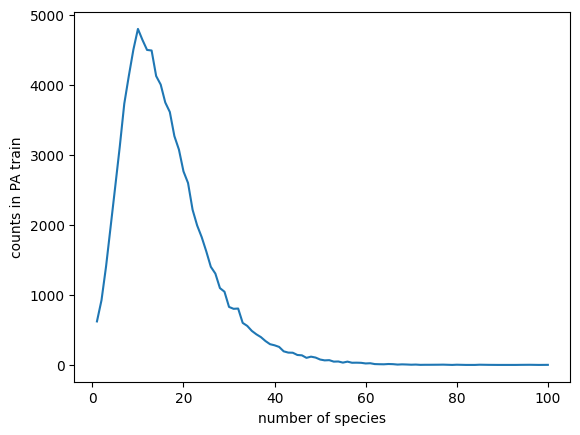

In [313]:
fig = plt.figure()
ax = plt.gca()
plt.plot(tmp.spLen.value_counts(sort=False))
ax.set_xlabel("number of species")
ax.set_ylabel("counts in PA train")
plt.show()

In [331]:
train_worldcover.sort_values("surveyId")["class"]

0        10
1        30
2        30
3        10
4        10
         ..
88982    10
88983    10
88984    30
88985    80
88986    10
Name: class, Length: 88987, dtype: int64

,surveyId,lat,lon,area,areaList,uncert,uncertList,region,country,speciesId,spLenOrig,spLen
surveyId,,,,,,,,,,,,
91555,91555,56.162990,9.632480,707.0,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1
114235,114235,56.230900,9.710200,707.0,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1
168111,168111,55.149840,10.377420,707.0,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1
1525390,1525390,55.130290,14.917600,707.0,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1
2141446,2141446,55.070090,11.997590,707.0,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1
2352074,2352074,55.685910,9.809740,707.0,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1
2977002,2977002,55.130170,14.918270,707.0,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1
3151606,3151606,56.831540,9.914520,707.0,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1
3414208,3414208,56.851320,9.858340,707.0,[707.0],10.0,[10.0],CONTINENTAL,Denmark,[963],1,1


Text(0, 0.5, 'richness')

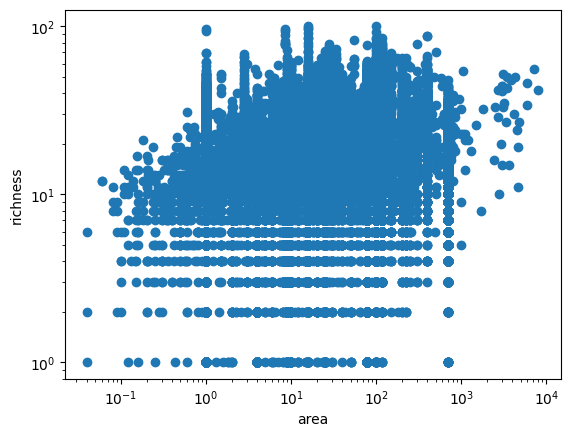

In [342]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(tmp.area, tmp.spLen)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("area")
ax.set_ylabel("richness")

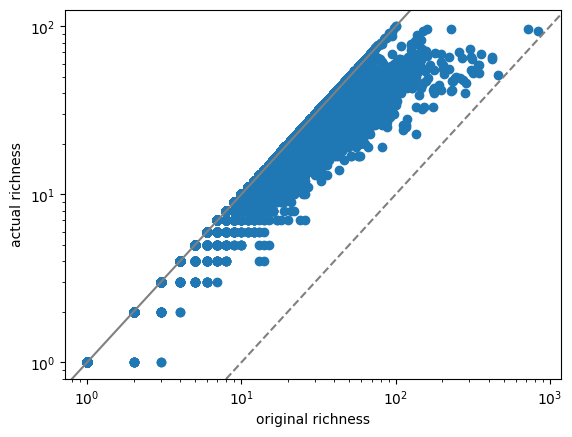

In [189]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(tmp.spLenOrig, tmp.spLen)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("original richness")
ax.set_ylabel("actual richness")
plt.axline([0,0],[1,1], color="gray")
plt.axline([10,1],[100,10], color="gray", linestyle="dashed")

In [130]:
train_worldcover[train_worldcover["class"]==70]

,surveyId,lon,lat,class
1813,82205,11.862286,46.266493,70
25193,1105349,10.799497,46.996250,70
44002,1940213,10.785264,46.999725,70
76466,3375818,10.784667,46.898394,70
79928,3529404,10.779789,47.007422,70


In [244]:
train_worldcover = pd.read_csv(os.path.join(path_data, "worldcover", "s2_pa_train_survey_points_with_worldcover.csv"))
display(train_worldcover.value_counts("class"))
train_wcdummy = pd.get_dummies(train_worldcover["class"], prefix="wc").set_index(train_worldcover.surveyId)
#pd.get_dummies(train_worldcover, columns=["class"])
train_wcdummy

class
30     42974
10     34374
90      3934
40      2737
60      2367
80       996
50       861
20       695
100       44
70         5
Name: count, dtype: int64

,wc_10,wc_20,wc_30,wc_40,wc_50,wc_60,wc_70,wc_80,wc_90,wc_100
surveyId,,,,,,,,,,
212,True,False,False,False,False,False,False,False,False,False
222,False,False,True,False,False,False,False,False,False,False
243,False,False,True,False,False,False,False,False,False,False
324,True,False,False,False,False,False,False,False,False,False
333,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
3919553,True,False,False,False,False,False,False,False,False,False
3919592,True,False,False,False,False,False,False,False,False,False
3919620,False,False,True,False,False,False,False,False,False,False


In [132]:
test_worldcover.value_counts("class")

class
30     6027
10     5110
40     1435
90      634
50      626
60      609
80      182
20      146
100      15
Name: count, dtype: int64

In [109]:
test_worldcover = pd.read_csv(os.path.join(path_data, "worldcover", "pa_test_survey_points_with_worldcover.csv"))
tmp = pd.get_dummies(test_worldcover["class"], prefix="wc").set_index(test_worldcover.surveyId)
tmp.insert(6, "wc_70", False)
tmp

,wc_10,wc_20,wc_30,wc_40,wc_50,wc_60,wc_70,wc_80,wc_90,wc_100
surveyId,,,,,,,,,,
642,True,False,False,False,False,False,False,False,False,False
1792,True,False,False,False,False,False,False,False,False,False
3256,False,False,True,False,False,False,False,False,False,False
3855,False,False,True,False,False,False,False,False,False,False
4889,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
5010108,False,False,False,True,False,False,False,False,False,False
5010109,False,False,True,False,False,False,False,False,False,False
5010110,False,False,False,False,False,False,False,False,True,False


In [113]:
test_worldcover

,surveyId,lon,lat,class
0,642,10.033550,57.120810,10
1,1792,7.333000,46.229970,10
2,3256,1.843658,42.580060,30
3,3855,11.720090,46.261490,30
4,4889,9.361870,55.902450,10
...,...,...,...,...
14779,5010108,34.958290,49.713370,40
14780,5010109,34.959519,45.784336,30
14781,5010110,34.960478,45.782300,90
14782,5010111,34.961731,45.781761,60


In [78]:
path_data = "/home/gt/DATA/geolifeclef-2025"
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata = train_metadata.dropna(subset="speciesId").reset_index(drop=True)
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)
train_metadata["speciesIdOrig"] = train_metadata['speciesId']
tmp = train_metadata["speciesId"].value_counts() >= pa_presence_threshold
train_metadata.loc[~train_metadata["speciesId"].isin(tmp[tmp].index), "speciesId"] = -1
sp_categorical = train_metadata["speciesId"].astype("category").values
num_classes = len(sp_categorical.categories)
train_metadata['speciesId'] = sp_categorical.codes
train_label_series = train_metadata.groupby('surveyId')['speciesId'].apply(list)
train_label_series

surveyId
212        [1805, 117, 2923, 2306, 1196, 2759, 2479, 242,...
222                               [2569, 133, 1187, 105, 59]
243        [1411, 844, 1580, 59, 1836, 370, 1219, 1410, 1...
324                         [2364, 620, 178, 2460, 35, 1787]
333        [643, 241, 1040, 2141, 2684, 1362, 495, 1323, ...
                                 ...                        
3919553    [1645, 2361, 764, 169, 592, 2544, 2691, 59, 25...
3919592                              [237, 1835, 1843, 2786]
3919620    [2569, 1073, 809, 2916, 133, 786, 1187, 516, 1...
3919640    [71, 866, 1925, 415, 2673, 1394, 1183, 844, 18...
3919655    [195, 1219, 2708, 1843, 1580, 1362, 210, 516, ...
Name: speciesId, Length: 88987, dtype: object

In [54]:
train_path_sentinel = os.path.join(path_data, "SatelitePatches/PA-train")
train_path_landsat = os.path.join(path_data, "SateliteTimeSeries-Landsat/cubes/PA-train")
train_path_bioclim = os.path.join(path_data, "BioclimTimeSeries/cubes/PA-train")
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata = train_metadata.dropna(subset="speciesId").reset_index(drop=True)
train_metadata['speciesId'] = train_metadata['speciesId'].astype(int)

In [55]:
train_label_series = train_metadata.groupby('speciesId')['surveyId'].apply(list)
species_label = pd.DataFrame(train_label_series)
#train_label_series = train_metadata.groupby('surveyId')['speciesId'].apply(list)
#train_label_series.apply(len)

,surveyId
speciesId,
2,"[249956, 876055, 890998, 958730, 1162857, 1176..."
3,[1974081]
4,"[62976, 124250, 172626, 298514, 334469, 685264..."
7,"[65365, 207414, 262936, 421888, 443273, 456884..."
9,"[2163, 10447, 24928, 35174, 50488, 90385, 1178..."
...,...
11245,"[60996, 3362732, 3659134]"
11246,[684812]
11248,"[418947, 792561, 792561, 1673706, 1673706, 177..."


In [32]:
pa_presence_threshold = 10
tmp = train_metadata["speciesId"].value_counts() >= pa_presence_threshold
train_metadata = train_metadata.loc[train_metadata["speciesId"].isin(tmp[tmp].index)]
train_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId,speciesIdNew
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874,212,6874
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476,212,476
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157,212,11157
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784,212,8784
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530,212,4530
...,...,...,...,...,...,...,...,...,...,...
1483632,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,53,3919655,53
1483633,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,5071,3919655,5071
1483634,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,1889,3919655,1889
1483635,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,10600,3919655,10600


In [56]:
sp_categorical = train_metadata["speciesId"].astype("category").values
sp_categorical.categories

Index([    2,     3,     4,     7,     9,    10,    12,    14,    15,    16,
       ...
       11239, 11240, 11241, 11242, 11243, 11245, 11246, 11248, 11253, 11254],
      dtype='int64', length=5016)

In [38]:
train_metadata["speciesIdNew"] = sp_categorical.categories[sp_categorical.codes]

In [58]:
int(1e6)

1000000

In [40]:
train_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId,speciesIdNew
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874,212,6874
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476,212,476
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157,212,11157
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784,212,8784
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530,212,4530
...,...,...,...,...,...,...,...,...,...,...
1483632,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,53,3919655,53
1483633,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,5071,3919655,5071
1483634,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,1889,3919655,1889
1483635,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,10600,3919655,10600


In [295]:
train_elevation = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "Elevation", "GLC25-PA-train-elevation.csv"))
train_elevation['Elevation'].fillna((train_elevation['Elevation'].mean()), inplace=True)
print(train_elevation.shape, train_elevation.isin([-np.inf]).sum(0).values, train_elevation.isin([-np.inf]).sum(0).values, train_elevation.isna().sum(0).values)

(88987, 2) [0 0] [0 0] [ 0 35]


In [296]:
test_elevation = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "Elevation", "GLC25-PA-test-elevation.csv"))
test_elevation['Elevation'].fillna((test_elevation['Elevation'].mean()), inplace=True)
print(test_elevation.shape, test_elevation.isin([-np.inf]).sum(0).values, test_elevation.isin([-np.inf]).sum(0).values, test_elevation.isna().sum(0).values)

(14829, 2) [0 0] [0 0] [0 0]


In [294]:
train_soil = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "SoilGrids", "GLC25-PA-train-soilgrids.csv"))
for column in train_soil.columns: train_soil[column].fillna((train_soil[column].mean()), inplace=True)
print(train_soil.shape, train_soil.isin([-np.inf]).sum(0).values, train_soil.isin([-np.inf]).sum(0).values, train_soil.isna().sum(0).values, sep='\n')

(88987, 10)
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0 8573 7512 7512 7512 7512 7512 7512 7512 8573]


In [298]:
test_soil = pd.read_csv(os.path.join(path_data, "EnvironmentalValues", "SoilGrids", "GLC25-PA-test-soilgrids.csv"))
for column in test_soil.columns: test_soil[column].fillna((test_soil[column].mean()), inplace=True)
print(test_soil.shape, test_soil.isin([-np.inf]).sum(0).values, test_soil.isin([-np.inf]).sum(0).values, test_soil.isna().sum(0).values, sep='\n')

(14829, 10)
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [19]:
combined = pd.concat([train_metadata, train_elevation.Elevation, train_soil.drop("surveyId", axis=1)], axis=1)
print(combined.isna().sum(0))
combined

lon                    0
lat                    0
year                   0
geoUncertaintyInM    521
areaInM2               0
region                 0
country                0
surveyId               0
Elevation              0
Soilgrid-bdod          0
Soilgrid-cec           0
Soilgrid-cfvo          0
Soilgrid-clay          0
Soilgrid-nitrogen      0
Soilgrid-phh2o         0
Soilgrid-sand          0
Soilgrid-silt          0
Soilgrid-soc           0
dtype: int64


,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,surveyId,Elevation,Soilgrid-bdod,Soilgrid-cec,Soilgrid-cfvo,Soilgrid-clay,Soilgrid-nitrogen,Soilgrid-phh2o,Soilgrid-sand,Soilgrid-silt,Soilgrid-soc
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,212,47.0,140.0,214.0,151.0,292.0,159.0,73.0,284.0,422.0,176.0
1,9.884560,56.912140,2017,10.0,79.0,CONTINENTAL,Denmark,222,6.0,120.0,225.0,101.0,94.0,379.0,58.0,650.0,255.0,609.0
2,8.256020,55.637050,2019,10.0,79.0,ATLANTIC,Denmark,243,10.0,115.0,261.0,86.0,131.0,373.0,54.0,750.0,117.0,672.0
3,-0.402590,43.505630,2018,1.0,-inf,ATLANTIC,France,324,116.0,118.0,179.0,117.0,225.0,230.0,57.0,238.0,535.0,302.0
4,-0.517360,45.806430,2017,1.0,-inf,ATLANTIC,France,333,84.0,138.0,233.0,176.0,328.0,250.0,71.0,231.0,439.0,257.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88982,10.327990,57.305850,2018,10.0,79.0,CONTINENTAL,Denmark,3919553,23.0,116.0,199.0,65.0,116.0,311.0,59.0,622.0,260.0,485.0
88983,15.003900,55.090170,2017,10.0,707.0,CONTINENTAL,Denmark,3919592,138.0,118.0,245.0,113.0,156.0,405.0,54.0,555.0,288.0,868.0
88984,8.935060,55.461500,2018,10.0,79.0,ATLANTIC,Denmark,3919620,37.0,113.0,233.0,70.0,71.0,253.0,56.0,798.0,129.0,414.0
88985,17.252948,53.901434,2021,5.0,25.0,CONTINENTAL,Poland,3919640,131.0,130.0,162.0,99.0,55.0,234.0,50.0,803.0,141.0,502.0


In [61]:
meta_columns = ["areaInM2", "Elevation"] + list(train_soil.columns[1:])
meta_columns

['areaInM2',
 'Elevation',
 'Soilgrid-bdod',
 'Soilgrid-cec',
 'Soilgrid-cfvo',
 'Soilgrid-clay',
 'Soilgrid-nitrogen',
 'Soilgrid-phh2o',
 'Soilgrid-sand',
 'Soilgrid-silt',
 'Soilgrid-soc']

In [13]:
train_metadata.value_counts(["areaInM2", "country"])

areaInM2  country    
 79.0     Denmark        42647
-inf      France         10258
 707.0    Denmark         6697
 4.0      Netherlands     4422
 9.0      Netherlands     2195
                         ...  
 90.0     Spain              1
 10.0     Norway             1
 90.0     Italy              1
          Germany            1
 8000.0   Netherlands        1
Name: count, Length: 866, dtype: int64

In [25]:
train_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_train.csv"))
train_metadata.groupby('surveyId')['speciesId'].apply(list)[212]

[6874.0,
 476.0,
 11157.0,
 8784.0,
 4530.0,
 10520.0,
 9458.0,
 982.0,
 51.0,
 3935.0,
 11193.0,
 2421.0,
 2159.0,
 9030.0,
 2932.0,
 1304.0]

In [ ]:
print(train_dataset[0][1].shape)
#val = np.zeros([len(train_dataset)])
#for i, d in enumerate(tqdm.tqdm(train_dataset)):
#    val[i] = torch.sum(torch.sum(torch.reshape(torch.permute(d[1], [0,2,1]), [6, -1]), -2) == 0).numpy()

In [ ]:
train_metadata.speciesId.drop_duplicates().sort_values()
prev_min = 10
train_metadata.value_counts("speciesId").sort_index().pipe(lambda x: x[x>=prev_min])

In [ ]:
plt.plot(np.log10(train_metadata.value_counts("speciesId").values))

In [111]:
test_metadata = pd.read_csv(os.path.join(path_data, "GLC25_PA_metadata_test.csv"))
test_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,surveyId
0,10.033550,57.120810,2019,10.0,707.0,CONTINENTAL,Denmark,642
1,7.333000,46.229970,2019,NaN,10.0,ALPINE,Switzerland,1792
2,1.843658,42.580060,2018,0.0,-inf,ALPINE,France,3256
3,11.720090,46.261490,2021,10.0,35.0,ALPINE,Italy,3855
4,9.361870,55.902450,2017,10.0,79.0,CONTINENTAL,Denmark,4889
...,...,...,...,...,...,...,...,...
14779,4.148978,43.989024,2021,4.0,150.0,MEDITERRANEAN,France,5000929
14780,3.523861,43.700529,2021,5.0,250.0,MEDITERRANEAN,France,5000922
14781,3.562852,43.864276,2021,5.0,250.0,MEDITERRANEAN,France,5000927
14782,3.557167,43.864581,2021,7.0,250.0,MEDITERRANEAN,France,5000925


In [ ]:
(train_metadata.country.value_counts().cumsum() / test_metadata.shape[0]).index[:10].values

In [ ]:

test_metadata.country.isin(most_train_countries).sum()

In [49]:
train_metadata

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874.0,212
1,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,476.0,212
2,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,11157.0,212
3,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,8784.0,212
4,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,4530.0,212
...,...,...,...,...,...,...,...,...,...
1483632,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,53.0,3919655
1483633,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,5071.0,3919655
1483634,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,1889.0,3919655
1483635,9.913980,56.827580,2018,10.0,707.0,CONTINENTAL,Denmark,10600.0,3919655


In [56]:
train_metadata_surv = train_metadata.drop_duplicates("surveyId")
train_summary = pd.DataFrame(train_metadata_surv.value_counts("country"))
train_summary["prop"] = train_summary.loc[:,"count"] / train_summary.loc[:,"count"].sum()
train_summary

,count,prop
country,,
Denmark,49344,0.554508
Netherlands,15024,0.168834
France,13501,0.151719
Italy,2602,0.029240
Belgium,1849,0.020778
Austria,1261,0.014171
Germany,1120,0.012586
Czech Republic,1051,0.011811
Montenegro,904,0.010159


In [57]:
test_summary = pd.DataFrame(test_metadata.value_counts("country"))
test_summary["prop"] = test_summary.loc[:,"count"] / test_summary.loc[:,"count"].sum()
test_summary["cumprop"] = test_summary.loc[:,"prop"].cumsum()
test_summary

,count,prop,cumprop
country,,,
Bulgaria,3273,0.221388,0.221388
Ukraine,2911,0.196902,0.418290
Switzerland,1982,0.134064,0.552354
France,1468,0.099297,0.651650
Denmark,1453,0.098282,0.749932
Netherlands,846,0.057224,0.807156
United Kingdom,843,0.057021,0.864177
Italy,558,0.037744,0.901921
Belarus,268,0.018128,0.920049


In [58]:
test_summary.join(train_summary, lsuffix="_test", rsuffix="_train")

,count_test,prop_test,cumprop,count_train,prop_train
country,,,,,
Bulgaria,3273,0.221388,0.221388,81.0,0.000910
Ukraine,2911,0.196902,0.418290,NaN,NaN
Switzerland,1982,0.134064,0.552354,155.0,0.001742
France,1468,0.099297,0.651650,13501.0,0.151719
Denmark,1453,0.098282,0.749932,49344.0,0.554508
Netherlands,846,0.057224,0.807156,15024.0,0.168834
United Kingdom,843,0.057021,0.864177,NaN,NaN
Italy,558,0.037744,0.901921,2602.0,0.029240
Belarus,268,0.018128,0.920049,NaN,NaN
